<h2>Trabalho Realizado Por:</h2>
<br>
Carlos Ferreira - a87953
<br>
Daniel Ribeiro - a87994

<h2>Exercício 1</h2>

1. Um sistema de tráfego  é representado por um grafo orientado ligado. Os nodos denotam pontos de acesso e  os arcos denotam vias de comunicação só com um sentido . 
    >  O grafo tem de ser ligado o que significa que entre cada par de nodos $\langle n_1,n_2 \rangle$ tem de existir um caminho $n_1 \leadsto n_2$ e um caminho $n_2\leadsto n_1$.
    

a. Gerar aleatoriamente o grafo. Assuma N=32 para o número de nodos. 
1. Cada nodo tem um número aleatório de descendentes no intervalo 1..d, cujos destinos são também gerados aleatoriamente.      Assume-se que não existem “loops” nem repetição de destinos.
        
Como as vias de comunicação só têm um sentido , escolhemos utilizar a função DiGraph (directed graph) do NetworkX. Primeiramente adicionamos os N nodos ao grafo, depois usamos uma função também do NetworkX (is_strongly_connected), que nos garante que para todos dois nodos n1 e n2 , existe um caminho de n1 -> n2 , e n2 -> n1. Enquanto o is_strongly_connected falhasse iriamos escolher dois nodos à sorte, verficar que não eram o mesmo nodo ( evitar loops ) , e verificamos se ainda não existe essa via de comunicação do grafo, e só depois de passar essas duas condições é que adicionávamos a via de comunicação ao grafo.

In [3]:
import networkx as nx
import itertools
import random
from timeit import timeit
import matplotlib.pyplot as plt
from z3 import *

def geraGrafo(N):
    
    G = nx.DiGraph()
    for i in range(N):
        G.add_node(i+1)

    while not nx.is_strongly_connected(G):
        x = random.randint(1, N)
        y = random.randint(1, N)
        if x != y and (x,y) not in G.edges():
            G.add_edge(x,y)
    
    # evitar grafos muito densos
    
    while G.number_of_edges() > 75:
        return geraGrafo(N)

    return G



Geramos assim um gráfico aleatório:

Numero de arestas: 69
Dicionario do grafo: 
{1: [2], 2: [26, 1, 29], 3: [4, 32], 4: [1], 5: [28, 21], 6: [18, 12], 7: [19, 16, 10], 8: [22, 29, 13], 9: [1], 10: [17], 11: [21], 12: [5, 29, 28], 13: [24, 17, 31, 22, 23], 14: [15, 24], 15: [8, 22, 31], 16: [5, 17, 32], 17: [19, 7, 20], 18: [30, 1], 19: [25], 20: [32, 10, 9], 21: [6, 25, 18], 22: [5, 25], 23: [14], 24: [9, 16, 29], 25: [12, 28], 26: [13, 27, 2], 27: [24], 28: [8], 29: [19, 11], 30: [24], 31: [3], 32: [1, 21, 25, 11]}


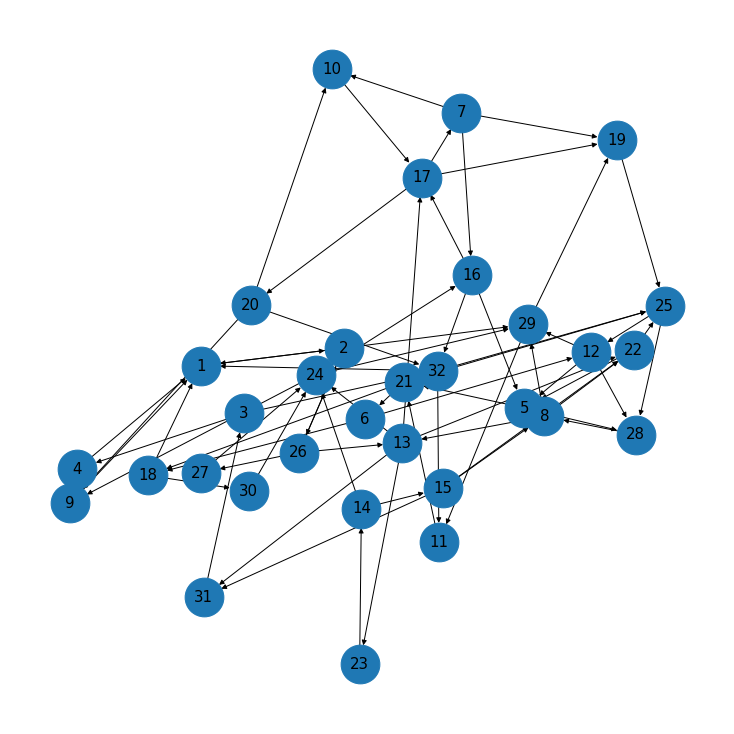

In [4]:
G = geraGrafo(32)
print("Numero de arestas: " + str(G.number_of_edges()))
print("Dicionario do grafo: ")
print(nx.to_dict_of_lists(G))
plt.figure(figsize=(10,10))
pos = nx.spring_layout(G) 
nx.draw(G, pos, font_size=15 , with_labels = True, node_size=1500)

Adicionalmente calculamos o tempo para 20 execuções da nossa função, podemos reparar que o tempo de execução é baixíssimo, demostrando assim a sua eficiência

Text(0, 0.5, 'tempo em sec')

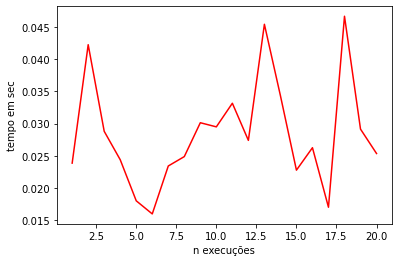

In [16]:
def tempos (n , v, f):
    
    t = []
    
    for i in range (1,v+1):
    
        time = timeit(setup="from __main__ import " + f ,\
                stmt= f +"("+ str(n) +")",number=1)
        t.append(time)
        
    return t

t = tempos (32 , 20 , "geraGrafo")
n = range (1,21)
plt.plot(n, t, 'r')
plt.xlabel('n execuções')
plt.ylabel('tempo em sec')


b. Pretende-se fazer  manutenção interrompendo  determinadas vias.


Determinar o maior número de vias que é possível remover mantendo o grafo ligado.
 

Para resolvermos este problema utilizamos lógica linear inteira.

A variável  "aresta (a,b) vai pertencer ao grafo depois da remoção" vai ser representada da forma $$ 0 \leq d_{(a,b)} \leq 1 $$.

Exeplificação de execução:

 Seja G = < V,E > um grafo aleatório e (a,b) $\in$ E.
 Imaginemos que no grafo existem dois caminhos que conectam a e b.
 
 Caminho 1: [(a,b)]
 
 Caminho 2: [(a,$\alpha$) , ($\alpha$,$\beta$) , ($\beta$,b)]
 
 As condições a ser adicionadas serão:
 
$$ d[(a,b)] == 1 \lor d[(a,\alpha)] + d[(\alpha,\beta)] +  d[(\beta,b)] == 3 $$

Que significa que ou o (a,b) vai pertencer ao grafo final, ou então as três outras arestas vão pertencer.
Usamos esta lógica para todas as arestas, declaramos o obj como sendo o numero total de arestas que vão pertencer ao grafo final, e minimizamos, obtendo assim o menor número de arestas tal que o grafo continua fortemente ligado.


In [5]:

def maxRemove (graph):
    
    sol = Optimize()
    d = {}
    
    for e in graph.edges():
        d[e] = Int ("aresta" + str(e))
        sol.add(d[e] >= 0 , d[e] <= 1)
        
    for e in graph.edges():
        a,b = e
        todoscaminhoAparaB = [] 
        for path in nx.all_simple_paths (graph , a , b):
            listaArestasPath = [d[(path[i],path[i+1])] for i in range(len(path) - 1)]
            todoscaminhoAparaB.append(listaArestasPath)
        sol.add(Or([Sum(listaArestasPath) == len(listaArestasPath) for listaArestasPath in todoscaminhoAparaB]))
            
    obj = Sum([d[e] for e in graph.edges()])
    sol.minimize(obj)
    
    if sol.check() == sat:
        m = sol.model()
        print (m)
    return  [e for e in graph.edges() if m[d[e]] == 1]
    
y = maxRemove(G)
print ("\n\nMáximo de vias a ser removidas : " + str(G.number_of_edges() - len(y)))

[aresta(32, 11) = 1,
 aresta(32, 25) = 0,
 aresta(32, 21) = 0,
 aresta(32, 1) = 0,
 aresta(29, 11) = 0,
 aresta(29, 19) = 1,
 aresta(26, 2) = 0,
 aresta(26, 13) = 1,
 aresta(25, 28) = 1,
 aresta(25, 12) = 0,
 aresta(24, 29) = 0,
 aresta(24, 16) = 1,
 aresta(24, 9) = 0,
 aresta(22, 25) = 0,
 aresta(22, 5) = 1,
 aresta(21, 18) = 1,
 aresta(21, 25) = 0,
 aresta(20, 9) = 1,
 aresta(20, 10) = 0,
 aresta(20, 32) = 1,
 aresta(18, 1) = 0,
 aresta(17, 19) = 0,
 aresta(16, 32) = 0,
 aresta(16, 17) = 1,
 aresta(16, 5) = 0,
 aresta(15, 31) = 1,
 aresta(15, 22) = 0,
 aresta(15, 8) = 0,
 aresta(14, 24) = 0,
 aresta(13, 22) = 0,
 aresta(13, 31) = 0,
 aresta(13, 17) = 0,
 aresta(13, 24) = 0,
 aresta(12, 28) = 0,
 aresta(12, 29) = 1,
 aresta(12, 5) = 0,
 aresta(8, 13) = 0,
 aresta(8, 29) = 0,
 aresta(8, 22) = 1,
 aresta(7, 10) = 1,
 aresta(7, 16) = 0,
 aresta(7, 19) = 0,
 aresta(6, 12) = 1,
 aresta(6, 18) = 0,
 aresta(5, 21) = 1,
 aresta(5, 28) = 0,
 aresta(3, 32) = 0,
 aresta(2, 29) = 0,
 aresta(2, 1)

In [11]:
def geraGrafo(N):
    
    G = nx.DiGraph()
    for i in range(N):
        G.add_node(i+1)

    while not nx.is_strongly_connected(G):
        x = random.randint(1, N)
        y = random.randint(1, N)
        if x != y and (x,y) not in G.edges():
            G.add_edge(x,y)
        while G.number_of_edges() > 70:
            G = geraGrafo(N)

    return G

from timeit import timeit

print("\ntempo para 5 nodos=  " + str(timeit(setup="from __main__ import geraGrafo,maxRemove", \
       stmt="maxRemove(geraGrafo(" + str(5) + "))",number=1))+ "\n")

print("\ntempo para 10 nodos=  " + str(timeit(setup="from __main__ import geraGrafo,maxRemove", \
       stmt="maxRemove(geraGrafo(" + str(10) + "))",number=1))+ "\n")

print("\ntempo para 15 nodos=  " + str(timeit(setup="from __main__ import geraGrafo,maxRemove", \
       stmt="maxRemove(geraGrafo(" + str(15) + "))",number=1)) + "\n")

print("\ntempo para 20 nodos=  " + str(timeit(setup="from __main__ import geraGrafo,maxRemove", \
       stmt="maxRemove(geraGrafo(" + str(20) + "))",number=1)) + "\n")

print("\ntempo para 25 nodos=  " + str(timeit(setup="from __main__ import geraGrafo,maxRemove", \
       stmt="maxRemove(geraGrafo(" + str(25) + "))",number=1)) + "\n")

print("\ntempo para 32 nodos=  " + str(timeit(setup="from __main__ import geraGrafo,maxRemove", \
       stmt="maxRemove(geraGrafo(" + str(32) + "))",number=1)) + "\n")



[aresta(5, 2) = 0,
 aresta(5, 3) = 0,
 aresta(4, 3) = 1,
 aresta(4, 5) = 0,
 aresta(4, 1) = 0,
 aresta(3, 2) = 1,
 aresta(1, 5) = 0,
 aresta(5, 1) = 1,
 aresta(3, 5) = 1,
 aresta(2, 3) = 1,
 aresta(1, 4) = 1]

tempo para 5 nodos=  0.18191600000000108

[aresta(10, 1) = 1,
 aresta(10, 6) = 0,
 aresta(10, 5) = 0,
 aresta(10, 9) = 0,
 aresta(9, 5) = 1,
 aresta(9, 4) = 0,
 aresta(9, 1) = 0,
 aresta(9, 3) = 0,
 aresta(8, 3) = 0,
 aresta(8, 5) = 0,
 aresta(8, 9) = 1,
 aresta(8, 4) = 0,
 aresta(7, 3) = 0,
 aresta(7, 1) = 0,
 aresta(7, 4) = 1,
 aresta(7, 10) = 0,
 aresta(6, 5) = 0,
 aresta(6, 1) = 0,
 aresta(5, 8) = 0,
 aresta(5, 4) = 0,
 aresta(5, 10) = 1,
 aresta(3, 9) = 0,
 aresta(2, 8) = 1,
 aresta(2, 6) = 0,
 aresta(2, 4) = 0,
 aresta(1, 9) = 0,
 aresta(1, 6) = 1,
 aresta(1, 5) = 0,
 aresta(6, 7) = 1,
 aresta(4, 3) = 1,
 aresta(3, 2) = 1]

tempo para 10 nodos=  0.7478005000000394

[aresta(15, 6) = 0,
 aresta(15, 10) = 0,
 aresta(15, 4) = 0,
 aresta(15, 2) = 1,
 aresta(14, 11) = 0,
 aresta(